In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 

In [2]:

import pandas as pd
from datetime import datetime, timedelta
import pandas as pd 
import numpy as np 
from datetime import date, timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

train = pd.read_csv('train.csv.zip')
train['DATE'] = pd.to_datetime(train['DATE'])
train = train[train.DATE>=pd.datetime(2016, 3, 15)].reset_index(drop=True)

# Unique ATMs
ATM_IDs = train.ATM_ID.unique()
def replace_week_ago(trainnine):
    fist_q =  trainnine.CLIENT_OUT.quantile(0.9)
    last_q = trainnine.CLIENT_OUT.quantile(0.1)
    mask = (trainnine.CLIENT_OUT > fist_q) | (trainnine.CLIENT_OUT < last_q) 
    trainnine['mask'] = mask
    trainnine['shifted'] = trainnine.CLIENT_OUT.shift(7)
    trainnine.loc[mask,['CLIENT_OUT','shifted', ]] = trainnine.loc[mask,['shifted', 'CLIENT_OUT']].values
    trainnine = trainnine.iloc[7:]
    return trainnine[['DATE', "ATM_ID", 'CLIENT_OUT']]


def apply_replace(train):
    train2 = train.iloc[:0].copy()
    ATM_IDs = train.ATM_ID.unique()
    for ATM in ATM_IDs:
        trainnine = train[(train.ATM_ID==ATM)].copy()
        trainnine = replace_week_ago(trainnine)
    #     print(trainnine.head())
        train2 = pd.concat([train2, trainnine])
    train = train2.copy()
    del train2
    return train
train = apply_replace(train)
train = apply_replace(train)

train.columns = ['Timestamp','ForecastId','Value']

def time_preprocess(X):
    X['Timestamp'] = pd.to_datetime(X['Timestamp'])
    X['year'] = X['Timestamp'].dt.year
    X['month'] = X['Timestamp'].dt.month 
    X['day'] = X['Timestamp'].dt.day
    X['week_day'] = X['Timestamp'].dt.weekday
    X['hour'] = X['Timestamp'].dt.hour
    X['minute'] = X['Timestamp'].dt.minute
    X['minute'] = X['minute'] // 15 * 15
    
    return X

def feature_preprocessing(train, test, cat_cols, cat_type='ohe'):
    
    X_train, X_test = train[cat_cols].copy(), test[cat_cols].copy()

    if (cat_type=='mean_enc'):
        for j in ['mean', 'max', 'min', 'median']:
            for i in cat_cols:
                X_train[i], X_test[i] = MeanEncodingTransforming(X_train[i], train[['Value']], X_test[i], j)
                X_train[i].columns = [i+'_'+j]
                X_test[i].columns = [i+'_'+j]
                
    if (cat_type=='ohe'):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        X_train = ohe.fit_transform(train[cat_cols])
        X_test = ohe.transform(test[cat_cols])
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
    
    return X_train, X_test 

def train_groupby(train, test, window, how):
    mean_values = train[['Value', 'week_day']][-window:].groupby(['week_day']).agg(how).reset_index()
    mean_values.columns = ['week_day', 'pred']
    test = pd.merge(test, mean_values, how='left', on = ['week_day'])  
    
    return test['pred'].fillna(np.mean(train['Value']))

def train_mean(train, window):
    mean_value = np.mean(train['Value'].reset_index(drop=True)[-window:])
    return mean_value

def calc_score(pred, fact, index_mult):
    return np.sum(abs(pred-fact)) / np.sum(fact) * 10000

def train_rf(X_train, y_train, X_valid):

    rf = RandomForestRegressor(max_features='sqrt', n_estimators=142, n_jobs=-1, random_state=4224)
    rf.fit(X_train, y_train, sample_weight=np.linspace(0.5, 1, X_train.shape[0]) )
    y_hat = rf.predict(X_valid)
    
    return y_hat


# train.columns = ['Timestamp','ForecastId','Value']
def time_preprocess(X):
    X['Timestamp'] = pd.to_datetime(X['Timestamp'])
    X['year'] = X['Timestamp'].dt.year
    X['month'] = X['Timestamp'].dt.month 
    X['day'] = X['Timestamp'].dt.day
    X['week_day'] = X['Timestamp'].dt.weekday
    X['hour'] = X['Timestamp'].dt.hour
    X['minute'] = X['Timestamp'].dt.minute
    X['minute'] = X['minute'] // 15 * 15
    
    return X

# val = train[['ForecastId','Value']].groupby('ForecastId').diff()
# val['Value'] = val['Value'].fillna(0)
# val['Value'] = (val['Value']==0) * 1
# val.columns = ['diff']
# train = pd.concat([train, val], axis=1)

# a = train[['ForecastId','diff']].groupby('ForecastId').apply(pd.rolling_sum, 7, min_periods=1)
# a.columns = ['ForecastId', 'to_drop']
# a = a['to_drop']
# train = pd.concat([train, a], axis=1)

# print(train.shape)
# train = train[train['to_drop']<=3].reset_index(drop=True)
# train = train[['Timestamp','ForecastId','Value']]
train = time_preprocess(train)
print(train.shape)

train = train[train.year>=2016].reset_index(drop=True)
train['year_month_weekday'] = train['year'].astype('str') + '_' + train['month'].astype('str') + '_' + train['week_day'].astype('str') 
features = train[['ForecastId', 'year_month_weekday', 'Value']].groupby(['ForecastId', 'year_month_weekday']).agg('mean').reset_index()
features = features.pivot(index='ForecastId', columns='year_month_weekday', values='Value')
features = features.fillna(0)


losses = []
iids = []

sub = pd.DataFrame({})
cat_cols = ['week_day','hour','minute','month']

pred_dates  = ['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10', '2017-09-11', '2017-09-12',
               '2017-09-13', '2017-09-14', '2017-09-15', '2017-09-16',
               '2017-09-17']

index_mult = 0

for i in ATM_IDs:
    
    # prepare train and test Dfs 
    days_in_train = 99999
    X_train = train[train['ForecastId']==i].reset_index(drop=True)[-days_in_train:].reset_index(drop=True)
    X_train['Value'] = abs(X_train['Value'])
       
    X_train['Value_log'] = np.log1p(X_train['Value'])
     
    # prepare 'train_v' and 'valid_v' data frames - for validation 
    X_test = pd.DataFrame({'Timestamp':pred_dates, 'ForecastId':i})
    X_test = time_preprocess(X_test)
    
    obs_in_test = 35
    X_train_v = X_train[:-obs_in_test].reset_index(drop=True)
    X_valid_v = X_train[-obs_in_test:].reset_index(drop=True)
    
    # prepare features 
        # for train
    X_train_ohe, X_test_ohe = feature_preprocessing(X_train, X_test, cat_cols, cat_type='ohe')
  
        # for validation 
    X_train_v_ohe, X_valid_v_ohe = feature_preprocessing(X_train_v, X_valid_v, cat_cols, cat_type='ohe')
    
        # group by mean
    y_hat_grby_mean = train_groupby(X_train_v, X_valid_v, window=999999, how='mean')
    y_hat_grby3_mean = train_groupby(X_train_v, X_valid_v, window=obs_in_test*3, how='mean')
    
        # group by median
    y_hat_grby_median = train_groupby(X_train_v, X_valid_v, window=999999, how='median')
    y_hat_grby3_median = train_groupby(X_train_v, X_valid_v, window=obs_in_test*3, how='median')
    
        # RandomForest 
    y_rf = train_rf(X_train_v_ohe, X_train_v['Value'], X_valid_v_ohe)
    y_rf_log = np.exp(train_rf(X_train_v_ohe, X_train_v['Value_log'], X_valid_v_ohe)) - 1
    
    score_grby_mean = calc_score(y_hat_grby_mean, X_valid_v['Value'], 0)
    score_grby3_mean = calc_score(y_hat_grby3_mean, X_valid_v['Value'], 0)
    score_grby_median = calc_score(y_hat_grby_median, X_valid_v['Value'], 0)
    score_grby3_median = calc_score(y_hat_grby3_median, X_valid_v['Value'], 0)
    
    score_rf = calc_score(y_rf, X_valid_v['Value'], index_mult)
    score_rf_log = calc_score(y_rf_log, X_valid_v['Value'], index_mult)
    
        # LightGBM
    y_lgb, lgb_opt = validate_lgb(X_train_v_ohe, X_train_v['Value'], X_valid_v_ohe, X_valid_v['Value'])
    y_lgb_mean, lgb_mean_opt = validate_lgb(X_train_v_meanenc, X_train_v['Value'], X_valid_v_meanenc, X_valid_v['Value'])
    y_lgb_log, lgb_opt_log = validate_lgb(X_train_v_ohe, X_train_v['Value_log'], X_valid_v_ohe, X_valid_v['Value_log'])
    y_lgb_log = np.exp(y_lgb_log) -1
    y_lgb_mean_log, lgb_mean_opt_log = validate_lgb(X_train_v_meanenc, X_train_v['Value_log'], X_valid_v_meanenc, X_valid_v['Value_log'])
    y_lgb_mean_log = np.exp(y_lgb_mean_log) -1
    
    
    y_hats     = [y_hat_grby_mean, y_hat_grby3_mean, 
                  y_hat_grby_median, y_hat_grby3_median, 
                  y_rf, y_rf_log, 
                 ]
    
    all_scores = [score_grby_mean, score_grby3_mean, 
                  score_grby_median, score_grby3_median, 
                  score_rf, 
                  score_rf_log, 
                 ]
    
    best_score = np.min(all_scores)
    
    models_names = ['mean_all', 'mean_3', 
                    'median_all', 'median_3', 
                    'rf', 'rf_mean', 
                   ]
    
    losses.append(best_score)
    
    temp_df = pd.DataFrame({'Timestamp':pred_dates, 'ForecastId':i})
    temp_df = time_preprocess(temp_df)
    
    if (score_grby_mean==best_score):
        y_hat = train_groupby(X_train, X_test, window=999999, how='mean')
    
    if (score_grby3_mean==best_score):
        y_hat = train_groupby(X_train, X_test, window=obs_in_test*3, how='mean')
        
    if (score_grby_median==best_score):
        y_hat = train_groupby(X_train, X_test, window=999999, how='median')
    
    if (score_grby3_median==best_score):
        y_hat = train_groupby(X_train, X_test, window=obs_in_test*3, how='median')

    if (score_rf==best_score):
        y_hat = train_rf(X_train_ohe, X_train['Value'], X_test_ohe)
        
    if (score_rf_log==best_score):
        y_hat = np.exp(train_rf(X_train_ohe, X_train['Value_log'], X_test_ohe)) -1    
        
    X_test['Value'] = y_hat
    sub = pd.concat([sub,X_test],axis=0)
    
    
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.plot(y_hats[np.argmin(all_scores)])
    ax.plot(X_valid_v['Value'].reset_index(drop=True))
    fig.savefig('pics/'+str(i)+'.jpg')   # save the figure to file
    # plt.show()
    plt.close(fig)
    
    print(i, 'Best model is', models_names[np.argmin(all_scores)])
    print('loss:', np.min(all_scores) )
    print('val score:', np.mean(losses),'+',np.std(losses) )
    print(dict(zip(models_names, all_scores)))
    print('-------------------------------')

sub = sub[['Timestamp', 'ForecastId', 'Value']]
sub.columns = ['DATE', 'ATM_ID', 'CLIENT_OUT']

sub.to_csv('submission.csv', index=False)

(151500, 9)


NameError: name 'validate_lgb' is not defined

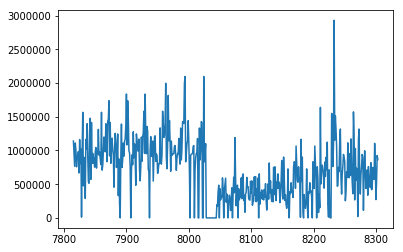

In [6]:
train = pd.read_csv('train.csv.zip')
train['DATE'] = pd.to_datetime(train['DATE'])
train = train[train.DATE>=pd.datetime(2016, 3, 15)].reset_index(drop=True)

# Unique ATMs
ATM_IDs = train.ATM_ID.unique()
def replace_week_ago(trainnine):
#     fist_q =  trainnine.CLIENT_OUT.quantile(0.9)
#     last_q = trainnine.CLIENT_OUT.quantile(0.1)
    mask = (trainnine.CLIENT_OUT == 0)
    trainnine['shifted'] = trainnine.CLIENT_OUT.shift(14)
    trainnine.loc[mask,['CLIENT_OUT','shifted', ]] = trainnine.loc[mask,['shifted', 'CLIENT_OUT']].values
    trainnine = trainnine.iloc[14:]
    return trainnine[['DATE', "ATM_ID", 'CLIENT_OUT']]


def apply_replace(train):
    train2 = train.iloc[:0].copy()
    ATM_IDs = train.ATM_ID.unique()
    for ATM in ATM_IDs:
        trainnine = train[(train.ATM_ID==ATM)].copy()
        trainnine = replace_week_ago(trainnine)
#         trainnine = replace_week_ago(trainnine)
#         trainnine = replace_week_ago(trainnine)
#         trainnine = replace_week_ago(trainnine)
    #     print(trainnine.head())
        train2 = pd.concat([train2, trainnine])
    train = train2.copy()
    del train2
    return train
train = apply_replace(train)
train[(train.ATM_ID == 21) & (train.DATE > pd.datetime(2017, 3, 30))].CLIENT_OUT.plot()

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt 

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd 
import numpy as np 
from datetime import date, timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

train = pd.read_csv('train.csv.zip')
train['DATE'] = pd.to_datetime(train['DATE'])
train = train[train.DATE>=pd.datetime(2017, 3, 15)].reset_index(drop=True)

# Unique ATMs
ATM_IDs = train.ATM_ID.unique()
def replace_week_ago(trainnine):
    fist_q =  trainnine.CLIENT_OUT.quantile(0.9)
    last_q = trainnine.CLIENT_OUT.quantile(0.1)
    mask = (trainnine.CLIENT_OUT > fist_q) | (trainnine.CLIENT_OUT < last_q) 
    trainnine['mask'] = mask
    trainnine['shifted'] = trainnine.CLIENT_OUT.shift(7)
    trainnine.loc[mask,['CLIENT_OUT','shifted', ]] = trainnine.loc[mask,['shifted', 'CLIENT_OUT']].values
    trainnine = trainnine.iloc[7:]
    return trainnine[['DATE', "ATM_ID", 'CLIENT_OUT']]


def apply_replace(train):
    train2 = train.iloc[:0].copy()
    ATM_IDs = train.ATM_ID.unique()
    for ATM in ATM_IDs:
        trainnine = train[(train.ATM_ID==ATM)].copy()
        trainnine = replace_week_ago(trainnine)
    #     print(trainnine.head())
        train2 = pd.concat([train2, trainnine])
    train = train2.copy()
    del train2
    return train
train = apply_replace(train)
train = apply_replace(train)
train.columns = ['Timestamp','ForecastId','Value']

def time_preprocess(X):
    X['Timestamp'] = pd.to_datetime(X['Timestamp'])
    X['year'] = X['Timestamp'].dt.year
    X['month'] = X['Timestamp'].dt.month 
    X['day'] = X['Timestamp'].dt.day
    X['week_day'] = X['Timestamp'].dt.weekday
    X['hour'] = X['Timestamp'].dt.hour
    X['minute'] = X['Timestamp'].dt.minute
    X['minute'] = X['minute'] // 15 * 15
    
    return X

def feature_preprocessing(train, test, cat_cols, cat_type='ohe'):
    
    X_train, X_test = train[cat_cols].copy(), test[cat_cols].copy()

    if (cat_type=='mean_enc'):
        for j in ['mean', 'max', 'min', 'median']:
            for i in cat_cols:
                X_train[i], X_test[i] = MeanEncodingTransforming(X_train[i], train[['Value']], X_test[i], j)
                X_train[i].columns = [i+'_'+j]
                X_test[i].columns = [i+'_'+j]
                
    if (cat_type=='ohe'):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        X_train = ohe.fit_transform(train[cat_cols])
        X_test = ohe.transform(test[cat_cols])
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
    
    return X_train, X_test 

def train_groupby(train, test, window, how):
    mean_values = train[['Value', 'week_day']][-window:].groupby(['week_day']).agg(how).reset_index()
    mean_values.columns = ['week_day', 'pred']
    test = pd.merge(test, mean_values, how='left', on = ['week_day'])  
    
    return test['pred'].fillna(np.mean(train['Value']))

def train_mean(train, window):
    mean_value = np.mean(train['Value'].reset_index(drop=True)[-window:])
    return mean_value

def calc_score(pred, fact, index_mult):
    return np.sum(abs(pred-fact)) / np.sum(fact) * 10000

def train_rf(X_train, y_train, X_valid):

    rf = RandomForestRegressor(max_features='sqrt', n_estimators=142, n_jobs=-1, random_state=4224)
    rf.fit(X_train, y_train, sample_weight=np.linspace(0.5, 1, X_train.shape[0]) )
    y_hat = rf.predict(X_valid)
    
    return y_hat


import lightgbm as lgb

def train_lgb(x_train, y_train, x_test):
    verbose = 1
    plot = 1
    params = {
    #     "max_bin": 1024,
    #     "learning_rate": 0.01,
        "boosting_type": "goss",
        "objective": "regression",
    #     'num_iterations':10000,
#         "metric": "auc",
    #     "num_leaves": 1000,
#         "verbose": 1,
    #     "min_data": 100,
    #     "boost_from_average": True
#         'early_stopping_round': 10,
    }

    d_train = lgb.Dataset(x_train, y_train)#, weight=np.linspace(0.5, 1, x_train.shape[0]))
#     d_valid = lgb.Dataset(x_test, label=y_test)
    model = lgb.train(params, d_train)

    return model.predict(x_test)


# train.columns = ['Timestamp','ForecastId','Value']
def time_preprocess(X):
    X['Timestamp'] = pd.to_datetime(X['Timestamp'])
    X['year'] = X['Timestamp'].dt.year
    X['month'] = X['Timestamp'].dt.month 
    X['day'] = X['Timestamp'].dt.day
    X['week_day'] = X['Timestamp'].dt.weekday
    X['hour'] = X['Timestamp'].dt.hour
    X['minute'] = X['Timestamp'].dt.minute
    X['minute'] = X['minute'] // 15 * 15
    
    return X

# val = train[['ForecastId','Value']].groupby('ForecastId').diff()
# val['Value'] = val['Value'].fillna(0)
# val['Value'] = (val['Value']==0) * 1
# val.columns = ['diff']
# train = pd.concat([train, val], axis=1)

# a = train[['ForecastId','diff']].groupby('ForecastId').apply(pd.rolling_sum, 7, min_periods=1)
# a.columns = ['ForecastId', 'to_drop']
# a = a['to_drop']
# train = pd.concat([train, a], axis=1)

# print(train.shape)
# train = train[train['to_drop']<=3].reset_index(drop=True)
# train = train[['Timestamp','ForecastId','Value']]
train = time_preprocess(train)
print(train.shape)

train = train[train.year>=2016].reset_index(drop=True)
train['year_month_weekday'] = train['year'].astype('str') + '_' + train['month'].astype('str') + '_' + train['week_day'].astype('str') 
features = train[['ForecastId', 'year_month_weekday', 'Value']].groupby(['ForecastId', 'year_month_weekday']).agg('mean').reset_index()
features = features.pivot(index='ForecastId', columns='year_month_weekday', values='Value')
features = features.fillna(0)


losses = []
iids = []

sub = pd.DataFrame({})
cat_cols = ['week_day','hour','minute','month']

pred_dates  = ['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10', '2017-09-11', '2017-09-12',
               '2017-09-13', '2017-09-14', '2017-09-15', '2017-09-16',
               '2017-09-17']

index_mult = 0

for i in ATM_IDs:
    
    # prepare train and test Dfs 
    days_in_train = 200
    mask = ((train.Timestamp > pd.datetime(2017, 6, 10)) | (train.Timestamp < pd.datetime(2017, 5, 1))) & (train['ForecastId']==i)
    X_train = train[mask].reset_index(drop=True)[-days_in_train:].reset_index(drop=True)
    X_train['Value'] = abs(X_train['Value'])
       
    X_train['Value_log'] = np.log1p(X_train['Value'])
     
    # prepare 'train_v' and 'valid_v' data frames - for validation 
    X_test = pd.DataFrame({'Timestamp':pred_dates, 'ForecastId':i})
    X_test = time_preprocess(X_test)
    
    obs_in_test = 35
    X_train_v = X_train[:-obs_in_test].reset_index(drop=True)
    X_valid_v = X_train[-obs_in_test:].reset_index(drop=True)
    
    # prepare features 
        # for train
    X_train_ohe, X_test_ohe = feature_preprocessing(X_train, X_test, cat_cols, cat_type='ohe')
  
        # for validation 
    X_train_v_ohe, X_valid_v_ohe = feature_preprocessing(X_train_v, X_valid_v, cat_cols, cat_type='ohe')
    
        # group by mean
    y_hat_grby_mean = train_groupby(X_train_v, X_valid_v, window=999999, how='mean')
    y_hat_grby3_mean = train_groupby(X_train_v, X_valid_v, window=obs_in_test*3, how='mean')
    
        # group by median
    y_hat_grby_median = train_groupby(X_train_v, X_valid_v, window=999999, how='median')
    y_hat_grby3_median = train_groupby(X_train_v, X_valid_v, window=obs_in_test*3, how='median')
    
        # RandomForest 
    y_rf = train_rf(X_train_v_ohe, X_train_v['Value'], X_valid_v_ohe)
    y_rf_log = np.exp(train_rf(X_train_v_ohe, X_train_v['Value_log'], X_valid_v_ohe)) - 1
    
    y_lgb = train_lgb(X_train_v_ohe, X_train_v['Value'], X_valid_v_ohe)
    y_lgb_log = np.exp(train_lgb(X_train_v_ohe, X_train_v['Value_log'], X_valid_v_ohe)) - 1
    
    score_grby_mean = calc_score(y_hat_grby_mean, X_valid_v['Value'], 0)
    score_grby3_mean = calc_score(y_hat_grby3_mean, X_valid_v['Value'], 0)
    score_grby_median = calc_score(y_hat_grby_median, X_valid_v['Value'], 0)
    score_grby3_median = calc_score(y_hat_grby3_median, X_valid_v['Value'], 0)
    
    score_rf = calc_score(y_rf, X_valid_v['Value'], index_mult)
    score_rf_log = calc_score(y_rf_log, X_valid_v['Value'], index_mult)
    
    score_lgb = calc_score(y_lgb, X_valid_v['Value'], index_mult)
    score_lgb_log = calc_score(y_lgb_log, X_valid_v['Value'], index_mult)
    
    
    y_hats     = [y_hat_grby_mean, y_hat_grby3_mean, 
                  y_hat_grby_median, y_hat_grby3_median, 
                  y_rf, y_rf_log,
                  y_lgb, y_lgb_log
                 ]
    
    all_scores = [score_grby_mean, score_grby3_mean, 
                  score_grby_median, score_grby3_median, 
                  score_rf, score_rf_log, 
                  score_lgb, score_lgb_log
                 ]
    
    best_score = np.min(all_scores)
    
    models_names = ['mean_all', 'mean_3', 
                    'median_all', 'median_3', 
                    'rf', 'rf_mean', 
                    'lgb', 'lgb_mean'
                   ]
    
    losses.append(best_score)
    
    temp_df = pd.DataFrame({'Timestamp':pred_dates, 'ForecastId':i})
    temp_df = time_preprocess(temp_df)
    
    if (score_grby_mean==best_score):
        y_hat = train_groupby(X_train, X_test, window=999999, how='mean')
    
    if (score_grby3_mean==best_score):
        y_hat = train_groupby(X_train, X_test, window=obs_in_test*3, how='mean')
        
    if (score_grby_median==best_score):
        y_hat = train_groupby(X_train, X_test, window=999999, how='median')
    
    if (score_grby3_median==best_score):
        y_hat = train_groupby(X_train, X_test, window=obs_in_test*3, how='median')

    if (score_rf==best_score):
        y_hat = train_rf(X_train_ohe, X_train['Value'], X_test_ohe)
        
    if (score_rf_log==best_score):
        y_hat = np.exp(train_rf(X_train_ohe, X_train['Value_log'], X_test_ohe)) -1    

    if (score_lgb==best_score):
        y_hat = train_lgb(X_train_ohe, X_train['Value'], X_test_ohe)
        
    if (score_lgb_log==best_score):
        y_hat = np.exp(train_lgb(X_train_ohe, X_train['Value_log'], X_test_ohe)) -1    
        
    X_test['Value'] = y_hat
    sub = pd.concat([sub,X_test],axis=0)
    
    
#     fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
#     ax.plot(y_hats[np.argmin(all_scores)])
#     ax.plot(X_valid_v['Value'].reset_index(drop=True))
#     fig.savefig('pics/'+str(i)+'.jpg')   # save the figure to file
#     # plt.show()
#     plt.close(fig)
    
#     print(i, 'Best model is', models_names[np.argmin(all_scores)])
#     print('loss:', np.min(all_scores) )
#     print('val score:', np.mean(losses),'+',np.std(losses) )
#     print(dict(zip(models_names, all_scores)))
#     print('-------------------------------')

sub = sub[['Timestamp', 'ForecastId', 'Value']]
sub.columns = ['DATE', 'ATM_ID', 'CLIENT_OUT']
sub.to_csv('submission.csv', index=False)

(42000, 9)
